In [1]:
from __future__ import division, print_function, unicode_literals, absolute_import
import numpy as np
import brainstorm as bs
import h5py
import pymongo
import gridfs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import subprocess
%matplotlib inline

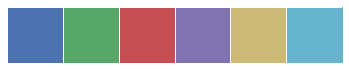

In [2]:
palette = sns.color_palette()
sns.palplot(palette)

In [3]:
def plot_subset(values, subset, alpha, ax, color=palette[0], label_step=None, ylim=None,
                xlabel='sample index', title='', use_subset=True):
    start, stop, step = subset.indices(inputs.shape[0])
    label_step = round((stop-start)/step/5) if label_step is None else label_step
    svals = values[subset] if use_subset else values
    ax.plot(svals, '.', alpha=alpha, color=color)
    xticks = np.arange((stop-start)//step, 0, -label_step)[::-1]
    xticklabels = np.arange(stop, start, -step*label_step)[::-1]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    if ylim:
        ax.set_ylim(ylim)
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    
    

# Investigate Fit
In this Notebook we take a trained network and look at its predictions. 
This way we can see how well the model captures the data.


### Get Network


In [4]:
net = bs.Network.from_hdf5('best_net.h5')

### get dataset

In [5]:
# Load the Dataset
with h5py.File('data50K.h5', 'r') as ds:
    training_data = {n:v[:] for n, v in ds['training'].items()}
    validation_data = {n:v[:] for n, v in ds['validation'].items()}
    mins = ds['training/default'].attrs['mins']
    maxs = ds['training/default'].attrs['maxs']
    tstd = ds['training/targets'].attrs['std']
    
train_iter = bs.data_iterators.Minibatches(128, shuffle=False, **training_data)
val_iter = bs.data_iterators.Minibatches(128, shuffle=False, **validation_data)

### run on training data

In [6]:
buffers = bs.tools.extract(net, train_iter,
                           ['Output.outputs.loss', 'Output.inputs.targets', 
                            'Output.outputs.predictions', 'Input.outputs.default'])

losses = buffers['Output.outputs.loss'][0, :, 0]
targets = buffers['Output.inputs.targets'][0, :, 0]
outputs = buffers['Output.outputs.predictions'][0, :, 0]
inputs = buffers['Input.outputs.default'][0, :, :]

### Plot losses, targets, and outputs (sorted by targets)

In [7]:
# sort them
train_sort_idxs = np.argsort(targets.flatten())
#train_sort_idxs = np.argsort(losses)

losses = losses[train_sort_idxs]
targets = targets[train_sort_idxs]
outputs = outputs[train_sort_idxs]
inputs = inputs[train_sort_idxs]

In [8]:
nr_samples = 49110
skip = 5
subset = slice(-nr_samples, None, skip)
subset_noskip = slice(-nr_samples, None)

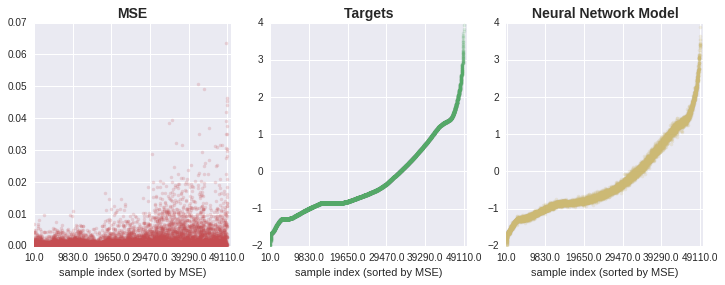

In [9]:
alpha=0.2
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
plot_subset(losses, subset, alpha, axes[0], title='MSE', xlabel='sample index (sorted by MSE)', color=palette[2])
plot_subset(targets, subset, alpha, axes[1], title='Targets', xlabel='sample index (sorted by MSE)', ylim=(-2, 4), color=palette[1])
#plot_subset(sim_results1[0], subset, 0.5, axes[2], title='simulation rerun', xlabel='sample index (sorted by MSE)', ylim=(-60, 60), color=palette[0], use_subset=False)
plot_subset(outputs, subset, alpha, axes[2], title='Neural Network Model', xlabel='sample index (sorted by MSE)', ylim=(-2, 4), color=palette[4])

In [10]:
fig.savefig('figures/net_output_train.pdf', bbox_inches='tight', pad_inches=0)

### run on validation

In [11]:
# Run a forward pass
net.provide_external_data(validation_data)
net.forward_pass()

In [12]:
# Get the losses and outputs
all_losses = net.buffer.Output.outputs.loss[0, :, 0]
targets = net.buffer.Output.inputs.targets[0, :, 0]
outputs = net.buffer.Output.outputs.predictions[0, :, 0]
inputs = net.buffer.Input.outputs.default[0, :, :]


In [13]:
# sort them
#val_sort_idxs = np.argsort(all_losses.flatten())
val_sort_idxs = np.argsort(targets.flatten())

all_losses = all_losses[val_sort_idxs]
targets = targets[val_sort_idxs]
outputs = outputs[val_sort_idxs]
inputs = inputs[val_sort_idxs]

In [14]:
nr_samples = 6000
skip = None
subset = slice(-nr_samples, None, skip)
subset_noskip = slice(-nr_samples, None)

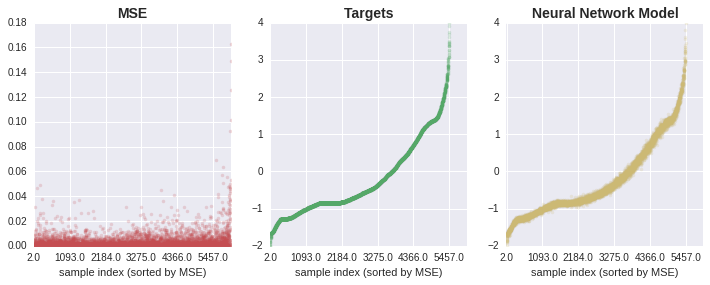

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
alpha = 0.2
plot_subset(losses, subset, alpha, axes[0], title='MSE', xlabel='sample index (sorted by MSE)', color=palette[2])
plot_subset(targets, subset, alpha, axes[1], title='Targets', xlabel='sample index (sorted by MSE)', ylim=(-2, 4), color=palette[1])
#plot_subset(sim_results1[0], subset, alpha, axes[2], title='simulation rerun', xlabel='sample index (sorted by MSE)', ylim=(-60, 60), color=palette[0], use_subset=False)
plot_subset(outputs, subset, alpha, axes[2], title='Neural Network Model', xlabel='sample index (sorted by MSE)', ylim=(-2, 4), color=palette[4])

In [16]:
fig.savefig('figures/net_output_valid.pdf', bbox_inches='tight', pad_inches=0)